In [1]:
print_imports()

Loaded modules:
numpy                np              1.14.0
pandas               pd              0.22.0
sklearn              sk              0.19.1
keras                ks              2.1.4

matplotlib           mpl             2.1.2
matplotlib.pyplot    plt             N/A
matplotlib.image     mpimg           N/A
seaborn              sns             0.8.1
PIL                  PIL             5.0.0

ExergyUtilities      exergy          2.0.

pyspark              pyspark         2.2.1


### Imports

In [125]:
import os, re, logging, json
from pprint import pprint
from keras import backend as K
from datetime import datetime
import random

In [3]:
mod_path = r"/home/batman/git/ai_drive/src"
sys.path.append(mod_path)
logging.debug("ADDED TO PATH: ".format(mod_path))

In [4]:
import drive.analysis_offline as analysis

### Paths

In [5]:
this_project_path = r"/media/batman/USB STICK"
project_name = r'catdog1'

### Plotting function

In [6]:
model_title = "10 Epochs"
def plot_hist(history_dict):
    #fig = plt.figure(figsize=(5,4))
    #fig=plt.figure(figsize=(20, 10),facecolor='white')

    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5),sharey=False,facecolor='white')
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5),sharey=False,facecolor='0.15')
    
    ax1.plot(history_dict['epoch'],  history_dict['history']['loss'],label="Train")
    ax1.plot(history_dict['epoch'],  history_dict['history']['val_loss'],label="CV")
    ax1.set_title("Loss function development - Training set vs CV set")
    ax1.legend(loc='upper right')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Values')
    
    ax2.plot(history_dict['epoch'],  history_dict['history']['acc'],label="Train")
    ax2.plot(history_dict['epoch'],  history_dict['history']['val_acc'],label="CV")
    ax2.set_title("Accuracy development - Training set vs CV set")
    ax2.legend(loc='upper right')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Values')
    
    plt.suptitle(model_title, fontsize=16)
    
    plt.show()

#plot_hist(history_dict)

```total_params = (filter_height * filter_width * input_image_channels + 1) * number_of_filters```

### Each loaded layer has a summary string

In [7]:
def Conv2D(params):
    #print(params['class_name'])
    #pprint(params['config'])
    kernel_dim = (params['config']['kernel_size'][0])
    filters = (params['config']['filters'])
    return "{}, kernel {}, filters {}".format(params['class_name'],kernel_dim,filters)

def MaxPooling2D(params):
    #print(params['class_name'])    
    #pprint(params['config'])
    pool_size = (params['config']['pool_size'][0])
    
    return "{}, pool {}".format(params['class_name'],pool_size)
def Flatten(params):
    #print(params['class_name'])
    return "{}".format(params['class_name'])

def Dropout(params):
    #print(params['class_name'])
    #pprint(params['config'])
    drp_rate = (params['config']['rate'])
    return "{}, dropout {}".format(params['class_name'],drp_rate)
    
    
    #raise
def Dense(params):
    #print(params['class_name'])
    return "{}".format(params['class_name'])

layer_funcs = {
        'Conv2D':Conv2D,
        'MaxPooling2D':MaxPooling2D,
        'Flatten':Flatten,
        'Dropout':Dropout,
        'Dense':Dense,
}

### Parameter counting

In [8]:
def count_params(model):
    """Uses backend 'K' count_params
    Returns dict for Total/Trainable/Non-trainable
    """
    trainable_count = int(
        np.sum([K.count_params(p) for p in set(model.trainable_weights)]))
    non_trainable_count = int(
        np.sum([K.count_params(p) for p in set(model.non_trainable_weights)]))
    return {'Total':trainable_count + non_trainable_count,'Trainable':trainable_count,'Non-trainable':non_trainable_count}
    #print('Total params: {:,}'.format(trainable_count + non_trainable_count))
    #print('Trainable params: {:,}'.format(trainable_count))
    #print('Non-trainable params: {:,}'.format(non_trainable_count))

In [31]:
%%script false
import re
date_re = re.compile('(?P<a_year>\d{2,4})-(?P<a_month>\d{2})-(?P<a_day>\d{2}) (?P<an_hour>\d{2}):(?P<a_minute>\d{2}):(?P<a_second>\d{2}[.\d]*)')
found = date_re.match('2016-02-29 12:34:56.789')
if found is not None:
    print found.groupdict()
#{'a_year': '2016', 'a_second': '56.789', 'a_day': '29', 'a_minute': '34', 'an_hour': '12', 'a_month': '02'}
found.groupdict()['a_month']
#'02'

In [42]:
def create_date(res_dict):
    #values = ['2014', '08', '17', '18', '01', '05']

    datevec = [ int(res_dict['year']),
                int(res_dict['month']),
                int(res_dict['day']),
                int(res_dict['hour']),
                int(res_dict['minute']),
                int(res_dict['second']),
              ]
    
    this_dt = datetime(*datevec)
    return this_dt


In [75]:
def parse_log_string(l):
    """datetime, log string text, module string
    """
    #log_regex = re.compile(r"(?P<year>\d{2,4})-(?P<month>\d{2})-(?P<day>\d{2}) (?P<hour>\d{2}):(?P<minute>\d{2}):(?P<second>\d{2}[.\d]*).*:\s(?P<logstring>.*)")
    #-- TODO !!!!
    log_regex = re.compile(r"(?P<year>\d{2,4})-(?P<month>\d{2})-(?P<day>\d{2}) (?P<hour>\d{2}):(?P<minute>\d{2}):(?P<second>\d{2}),[\d]*\s-\s(?P<level>\d\d)\s*-\s(?P<module_str>.*).*:\s(?P<logstring>.*)$")
    #log_regex = re.compile(r"(?P<year>\d{2,4})-(?P<month>\d{2})-(?P<day>\d{2}) (?P<hour>\d{2}):(?P<minute>\d{2}):(?P<second>\d{2}),[\d]*\s-\s(?P<level>\d\d)\s*-\s*(?P<modules>.*)\s:\s(?P<logstring>.*)$")
    res = log_regex.match(l)
    res_dict = res.groupdict()
    
    logstr = res_dict.pop('logstring', None)
    module_str = res_dict.pop('module_str', None)
        #print(res_dict)
    this_dt = create_date(res_dict)    
    
    return({'dt':this_dt,'logstr':logstr,'modstr':module_str})

In [106]:
def get_log_file(this_run_path):
    log_file = [os.path.join(this_run_path,f) for f in os.listdir(this_run_path) 
             if re.match('^log.txt$',f)][0]
    assert os.path.exists(log_file)
    
    with open(log_file) as f:
        #for l in lines:
            #print(l)
        lines = f.readlines()
        #content = [x.strip() for x in content] 
    
    start_time = parse_log_string(lines[0])['dt']
    end_time = parse_log_string(lines[-1])['dt']
    elapsed = end_time-start_time
    finish_found = None
    generator = None
    #for l in lines[-100:-1]:
    for l in lines[0:100]:        
        l = l.strip()
        res_dict = parse_log_string(l)
        
        # Get the image generator
        if not generator: 
            gen_regex = re.compile(r"get_train_generator")
            generator_line = gen_regex.search(res_dict['modstr'])
            #generator_line = gen_regex.match(res_dict['logstr'])
            if generator_line:
                #print(generator_line.group())
                #print()
                generator = res_dict['modstr']
                #raise
            #my_generators         
    
        
        
        # Check if finished
        finished_regex = re.compile(r"Finished training")
        finished_line = finished_regex.match(res_dict['logstr'])
        if finished_line: 
            finish_found=True

    
    return({'finished':finish_found,'start':start_time,'elapsed':elapsed,'generator':generator})
    #assert(finish_found)


### Main

In [118]:
root_path = os.path.join(this_project_path,project_name)
run_folders = [dir for dir in os.listdir(root_path) if re.match('run',dir)]
run_folders.sort()

# Loop run folders
for rfolder in run_folders:
    this_run_path = os.path.join(root_path,rfolder)
    logging.debug('**** RUN {} ****'.format(rfolder))
    
    ###### Log file ######
    log = get_log_file(this_run_path)
    print('start;',log['start'])
    print('elapsed; {:.1f}'.format(log['elapsed'].seconds/60))
    print('generator;',log['generator'])
    #raise
    ###### Weights ######
    wts = analysis.get_weights(this_run_path)
    if wts: best_wt = wts[-1] # BEST weight (last weight)
    
    ###### Architecture ######
    model = analysis.load_model(this_run_path)
    arch_dict = analysis.read_model_json(this_run_path)
    
    #model.summary()
    print(count_params(model))
    
    ##### Reload weights #####
    if wts:
        print(best_wt)
        model.load_weights(best_wt['path'])
    
    #raise
    ###### Loop layers ######
    for i,layer in enumerate(arch_dict['config']):
        layer_str = layer_funcs[layer['class_name']](layer)
        print(i,layer_str)

    ###### History ######
    path_hist = analysis.get_history(this_run_path)    
    with open(path_hist) as hist_file:
        hist_dict = json.load(hist_file)
    print("Epochs",hist_dict['params']['epochs'])
    print("Steps",hist_dict['params']['steps'])
    
    #plot_hist(hist_dict)
    del model
    raise


root  - 10  - <ipython-input-118-13c23eb08fdf>  <module>                      : **** RUN run078 ****
start; 2018-03-09 07:29:20
elapsed; 103.9
generator; my_generators         get_train_generator_simple    : Training
root  - 10  - analysis_offline      get_weights                   : Found 25 weights files, total 660 MB = 26.4 MB per file
{'Total': 3453121, 'Trainable': 3453121, 'Non-trainable': 0}
{'epoch': 50, 'fname': 'weights-epoch50-0.91.hdf5', 'path': '/media/batman/USB STICK/catdog1/run078/weights-epoch50-0.91.hdf5', 'size': 26.384925842285156}
0 Conv2D, kernel 3, filters 32
1 MaxPooling2D, pool 2
2 Conv2D, kernel 3, filters 64
3 MaxPooling2D, pool 2
4 Conv2D, kernel 3, filters 128
5 MaxPooling2D, pool 2
6 Conv2D, kernel 3, filters 128
7 MaxPooling2D, pool 2
8 Flatten
9 Dropout, dropout 0.5
10 Dense
11 Dense
/media/batman/USB STICK/catdog1/run078/history run078.txt
Epochs 50
Steps 400.0


RuntimeError: No active exception to reraise

Test data path and solutions csv

In [197]:
this_project_path = r"/media/batman/USB STICK"
project_name = r'catdog1'
root_path = os.path.join(this_project_path,project_name)
path_solutions = os.path.join(root_path,".csv")
path_test = r"/home/batman/Dropbox/DATA/cats_dogs_all/test"
test_image_paths =  [os.path.join(path_test,i) for i in os.listdir(path_test)]
#print(test_image_paths[0:2])
print(len(test_image_paths))
#root_path

12500


Test data generator

In [229]:
import keras.preprocessing.image

test_datagen = ks.preprocessing.image.ImageDataGenerator(rescale=1. / 255)
print(path_test)
test_generator = test_datagen.flow_from_directory(
        path_test,
        target_size = (150,150),
        batch_size = 8,
        #class_mode = "binary",
    );
test_generator[0][0].shape

/home/batman/Dropbox/DATA/cats_dogs_all/test
Found 12500 images belonging to 1 classes.


(8, 150, 150, 3)

Get a batch of images and predictions

In [303]:
img_list = list()
for img_batch_tensor,_ in test_generator:
    #print(i)
    print(img_batch_tensor.shape)
    
    #print(len(i))
    predictions = model.predict(img_batch_tensor)
    for img in img_batch_tensor:
        img_list.append(img)
    break #raise

predictions = [i[0] for i in predictions]
               
for p in predictions:
    break
    print("{:.3f}".format(p))

img_pred_list = list(zip(img_list,predictions))
#len(img_pred_list)

(8, 150, 150, 3)


Images

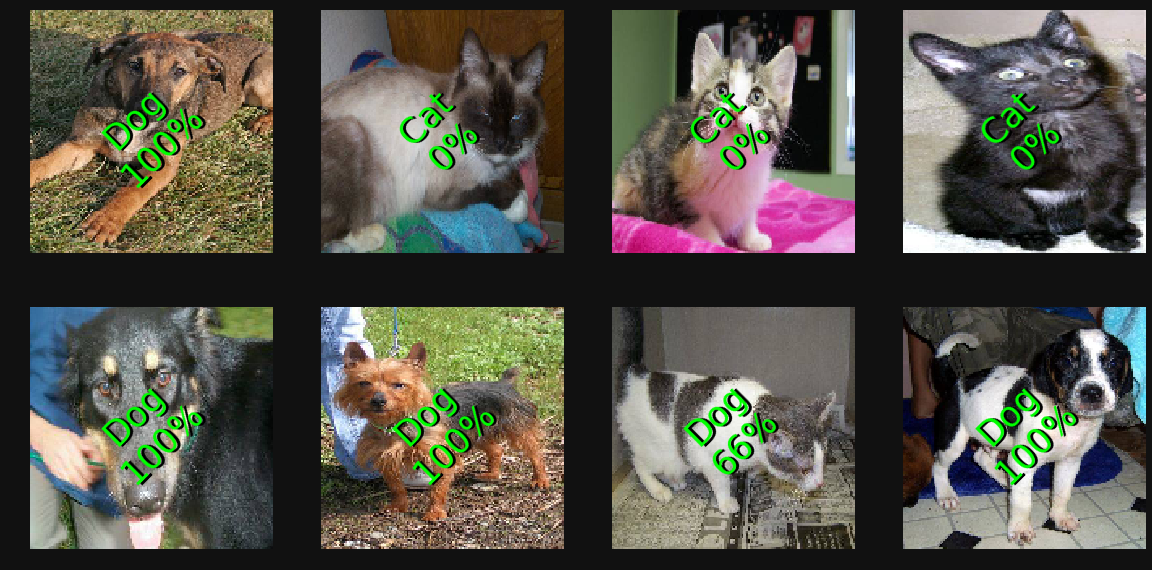

In [302]:
fig=plt.figure(figsize=(20, 10),facecolor=color)
columns = 4
rows = 2
predicted_class = None
for i,img_pred in enumerate(img_pred_list):
    #print(i)
    i = i+1
    img,pred = img_pred
    
    #print(img)
    #raise
    #img = img_list[i]
    #img=mpimg.imread(this_img_path)
    
    #img = mpimg.open(this_img_path)
    #img.load()
    
    
    #img = Image.open(this_img_path)
    #img.load()
    #print(pred)
    proba_str = "{:.0f}%".format(pred*100)
    if pred < 0.5:
        predicted_class = 'Cat'
    elif pred >= 0.5:
        predicted_class = 'Dog'
    else:
        raise
    
    
    this_ax = fig.add_subplot(rows, columns, i)

    #this_ax.set_title("{} {} {}".format(name, number, img.shape,))
    #this_ax.set_title("{} {}".format(predicted_class, proba_str))
    
    label_str =  predicted_class + '\n' + proba_str
    
    plt.text(150/2, 150/2, label_str, {'ha': 'center', 'va': 'center'}, rotation=45,size=35, color='black')
    plt.text(150/2-2, 150/2, label_str, {'ha': 'center', 'va': 'center'}, rotation=45,size=35, color='lime')
    #color : color


    plt.imshow(img)
    plt.axis("off")
plt.show()

In [ ]:
with open('submission_file.csv','w') as f:
    f.write('id,label\n')
            
with open('submission_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))

Make a single prediction

In [ ]:

    #img=mpimg.imread(this_img_path)
    
    #img = mpimg.open(this_img_path)
    #img.load()
    
    
    #img = Image.open(this_img_path)
    #img.load()



    
    this_ax = fig.add_subplot(rows, columns, i)

    this_ax.set_title("{} {} {}".format(name, number, img.shape,))
    plt.imshow(img)
    plt.axis("off")
plt.show()

In [200]:
this_img_path = random.sample(test_image_paths,1)[0]
assert os.path.exists(this_img_path)
fname = os.path.split(this_img_path)[-1]
name, ext = fname.split(".")
num = int(name)

img=mpimg.imread(this_img_path)
#nop = np.array([None])
img = img[np.newaxis]
print(img.shape)
#img = np.append(nop, )
#cd_predict(model,img)
#model.predict(img, verbose=0)
#fit_img = test_datagen.fit(img)
fit_img_gen = test_datagen.flow(img)
for fit_img in fit_img_gen:
    print(fit_img.shape)
    model.predict(fit_img)



PIL.Image - 10  - Image                 close                         : Error closing: 'NoneType' object has no attribute 'close'
(1, 291, 499, 3)
(1, 291, 499, 3)


ValueError: Error when checking : expected conv2d_1_input to have shape (150, 150, 3) but got array with shape (291, 499, 3)

Get a sample

In [142]:
sample = random.sample(test_image_paths,1)
for p in sample:
    print(p)

/home/batman/Dropbox/DATA/cats_dogs_all/test/4766.jpg


In [165]:
def cd_predict(model,img):
    print("making predictions on test set...")
    predictions = model.predict(img, verbose=0)
    return predictions


In [167]:
model.evaluate(test_data, test_labels_one_hot)

NameError: name 'test_data' is not defined

In [161]:
#import Image
#

color = (17/255,17/255,17/255)


NameError: name 'Image' is not defined

In [119]:
#model


In [120]:
predictions = model.predict(test, verbose=0)

NameError: name 'test' is not defined

In [ ]:
for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i].T)
    plt.show()